<a href="https://colab.research.google.com/github/MaggieWelch/labs/blob/main/PCA_MW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!git clone https://github.com/DS3001/labs.git
import os
os.chdir('labs/05_PCA')

Cloning into 'labs'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 97 (delta 37), reused 40 (delta 24), pack-reused 31 (from 1)
Receiving objects: 100% (97/97), 22.16 MiB | 18.80 MiB/s, done.
Resolving deltas: 100% (39/39), done.


#Q1

In [22]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


To predict whether an email is a phishing scam, I would start by cleaning the text—removing irrelevant words, symbols, and numbers, and standardizing the text by converting it to lowercase. Next, I would use one-hot encoding to transform the text into numerical features. To improve efficiency, I would apply Principal Component Analysis (PCA). Afterward, I’d train a linear model, such as logistic regression, on the processed data. Finally, I would assess the model’s performance using evaluation metrics.


#Q2

<Axes: >

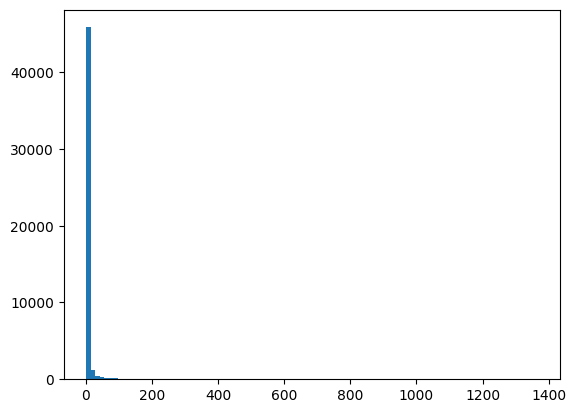

In [23]:
with open('all_tokens.pickle','rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

#plot histogram of token occurances
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

The histogram shows a highly skewed distribution, with most tokens occurring infrequently, while a few tokens appear very frequently. This suggests that there are many rare tokens and a small number of common tokens dominating the dataset.

#Q3

In [25]:
df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

#1.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

#2.
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


In [26]:
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


The R2 on the training set is .62, however the test set has an extremely small R2, indicating that it is overfitting and not capturing patterns to indicate if an email is a scam. The words that have the largest coefficients in absolute value are various numbers.

#Q4

<Axes: >

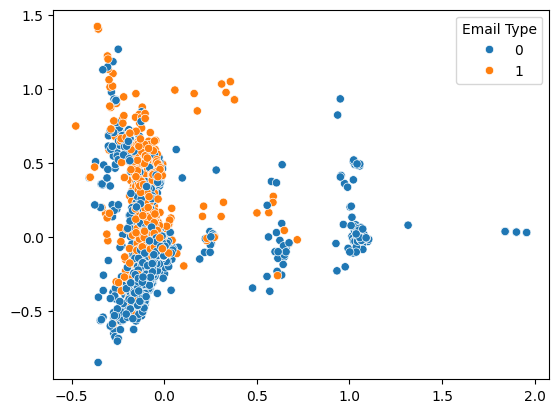

In [27]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The scatter plot shows some separation between phishing emails (orange) and non-phishing emails (blue), especially along the x-axis. However, the clusters are not clearly distinct, suggesting that the principal components don't fully capture the difference between the two types of emails.

#Q5

In [28]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('train r2: ', r2_score(y_hat_train,y_train) )
print('test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


This model performed much better than the linear regression, as the R2 for the test data is significantly higher than before. The model is still not fitting the test data as well as the train data however.

#Q6

Using principal components in high-dimensional regression helps reduce the complexity of the data by transforming it into a smaller set of uncorrelated features. This makes the model more efficient and less prone to overfitting, as it focuses on the most important patterns in the data while ignoring noise and irrelevant features from the original high-dimensional data.